# Imports

In [124]:
import os                                   # Find files in subdirectory 
import stl                                  # Read in stl files
from stl import mesh                        # Read in stl files
import random                               # Generate random numbers
import numpy as np                          # General work with arrays
import matplotlib.pyplot as plt             # Plotting
from mpl_toolkits import mplot3d            # 3D Plotting
from pyquaternion import Quaternion         # Rotate a set of xyz coordinates
import math                                 # Generate Pi
import time                                 # Timestamp creation
import datetime                             # Formatting Timestamps
import sys                                  # Flush sytem printouts

# Custom Functions

In [13]:
''''Background on STL format: "An StL (“StereoLithography”) file is a triangular 
representation of a 3-dimensional surface geometry. The surface is tessellated or 
broken down logically into a series of small triangles (facets). Each facet is 
described by a perpendicular direction and three points representing the vertices 
(corners) of the triangle" - https://www.fabbers.com/tech/STL_Format
      
Unfortunately the vertices contained within an STL file are not evenly distributed
over the models surface. Most often areas of high curvature contain a high 
proportion of the vertices. The "surface_sample" function takes in the coordinates
of the vertices in the form of three arrays with the x,y,z coordinates of each 
(vertex1, vertex2, vertex3) and randomly selects points within these vertices 
(on the surface of the facet). The quantity of points generated on each facet is 
proportional to the area of the facet. Thus points will be sampled evenly over the
entire surface of the STL. This approach is explained in great detail at this link
- https://medium.com/@daviddelaiglesiacastro/3d-point-cloud-generation-from-3d-triangular-mesh-bbb602ecf238  
      
The total number of points sampled can be defined by specifying sample size with 
any integer' '''   

def surface_sample(vertex1, vertex2, vertex3, sample_size):
    # Calculates the area of each facet
    Area =  0.5*np.linalg.norm(np.cross(vertex2 - vertex1, vertex3-vertex1), 
                               axis = 1) 
    # Creates a list of facet selection probability based on size of facet area
    Probabilities = Area/Area.sum() 
    # Creates a list of the selected facets based on calculated probabilites
    Selection = np.random.choice(range(len(Area)), size=sample_size, 
                                 p=Probabilities)
    
    # Narrow down the lists of vertices just to just those selected 
    vertex1 = vertex1[Selection]
    vertex2 = vertex2[Selection]
    vertex3 = vertex3[Selection]

    # Randomly select a point on the surface of each facet
    u = np.random.rand(sample_size, 1)
    v = np.random.rand(sample_size, 1)
    is_a_problem = u + v > 1
    u[is_a_problem] = 1-u[is_a_problem]
    v[is_a_problem] = 1-v[is_a_problem]
    w = 1-(u+v)
    
    # Output array of the xyz coordinates of each point sampled on STL surface  
    result = (vertex1*u)+(vertex2*v)+(vertex3*w)
    return result

In [15]:
""""Rotate an array of xyz coordinates about an axis through a defigned angle. 
For more details on the library used refer to - http://kieranwynn.github.io/pyquaternion/
The rotation axis is created with two points. The first is always assumed to be 
[0,0,0] and the second must be specified.
The ammount of rotation ('theta') must be defigned in radians" """

def Rotate(Array, axis, theta):
    for i in range (Array.shape[0]):
        Array[i] = Quaternion(axis=axis,angle=theta).rotate(Array[i])
    return Array

In [16]:
""""This function scales an array of xyz coordinates to the desired size
Array is the input array of vectors, size is the desired cube size that all vectors 
will fit within (whilst maintaining 3D aspect ratio)" """

def Scale(Array, size):
    # Ensures that all vectors are positive
    if Array[:,0].min()<0:
        Array[:,0] = Array[:,0] - Array[:,0].min()
        
    if Array[:,1].min()<0:
        Array[:,1] = Array[:,1] - Array[:,1].min()
    
    if Array[:,2].min()<0:
        Array[:,2] = Array[:,2] - Array[:,2].min()
        
    #Expands the array such that it will fit within a cube of defined "size"  
    Array = ((size)/(Array.max()))*Array
    return Array

# Dataset Generation

In [121]:
# Specify required variables
dataset_size = 10000 # Number of samples to be generated
array_cube_size = 50 # Cube size (that the 3D model must fit within)  
PointCloudSize = 50000 # Quantity of points sampled over the surface of the 3D model
path = 'training' # Name of folder in working directory where stl files are stored  

In [125]:
Training = np.empty((0, 3*PointCloudSize)) # initiate a numpy array to hold generated data 
t = time.process_time() # Step start time

fail = [] # initiate list to be filled with names of any STL files that fail to open
files = [f for f in os.listdir(path) if f.endswith('.stl')] # Create a list of all the stl files available

for i in range(dataset_size):
    while True: # Ensures that if there is an stl file which fails to open this step wont fail
        try:
            selection = random.randint(1,(len(files)-1))
            data_path = path + '/'+files[selection]
            STL = mesh.Mesh.from_file(data_path,remove_empty_areas=True)

    
            STL_0 = STL.vectors[:,0,:]
            STL_1 = STL.vectors[:,1,:]
            STL_2 = STL.vectors[:,2,:]
    
            Array3D = surface_sample(STL_0, STL_1, STL_2, PointCloudSize)
        
        except:
            fail.append(files[selection]) # add name of any STL that failed to open to a list
            continue
        break   
    
    # The RotVecs function can be time intensive for high dataset_size or PointCloudSize. 
    # If not required the following function can be deleted to expedite run time
    Array3D = RotVecs(Array3D, [random.uniform(0, 1),
                                random.uniform(0, 1),
                                random.uniform(0, 1)], 
                      random.uniform(0, math.pi))
    
    Array3D = Scale(Array3D, array_cube_size) 
    combined = np.concatenate((Array3D[:,0],Array3D[:,1],Array3D[:,2]), axis = 0) 
    Training = np.append(Training, [combined], axis=0) 
    
    PercentCompletion = ((((i+1)/dataset_size)*100)) # Calculate percatage data already generated
    elapsed_time = time.process_time() - t # Calculate total runtime
    RemainingTime = int((elapsed_time/PercentCompletion)*(100-PercentCompletion)) # Estimate time remaining
    
    #Print out Status Updates
    sys.stdout.flush() 
    print("\r" +"Percent Completion:" + str(int(PercentCompletion))+'%'
          +'   '+'Time Remaining Estimate (hrs:min:sec): '+str(datetime.timedelta(seconds=RemainingTime)), end='')

#Print out to total run time upon completion
print("\n" + "Completed! Total Run Time (minutes): " +str(int(elapsed_time/60)))

# If any of the STL files could not be opened print out their names so that the issue can be root caused
if len(fail)>0:
    fail = list(set(fail))
    print("\n" + "The following STL files could not be opened: ")
    for i in fail:
        print("\n" + i)

Percent Completion:100%   Time Remaining Estimate (hrs:min:sec): 0:00:00
Completed! Total Run Time (minutes): 941

The following STL files could not be opened: 

74463.stl


# Plot some samples from the Generated Dataset

In [131]:
# Specify the required variables
Samples = 5 # Specify how many samples to plot 
Color = 'red' # Set the color to plot the point cloud in
Alpha = 0.3 # Set transparency of each point plotted
size = 0.2 #Set the size of each point plotted

ID of Selection Plotted: 3976


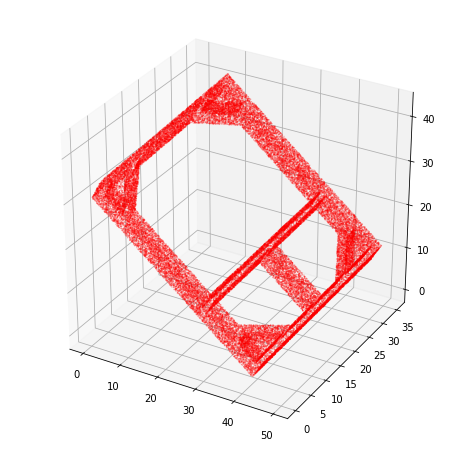

ID of Selection Plotted: 7662


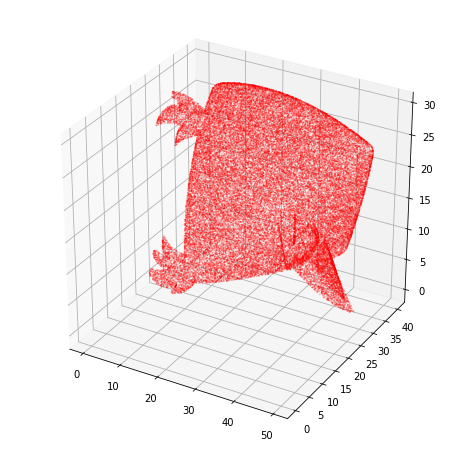

ID of Selection Plotted: 11


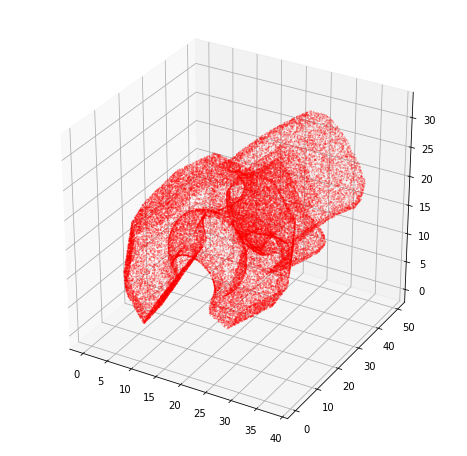

ID of Selection Plotted: 5123


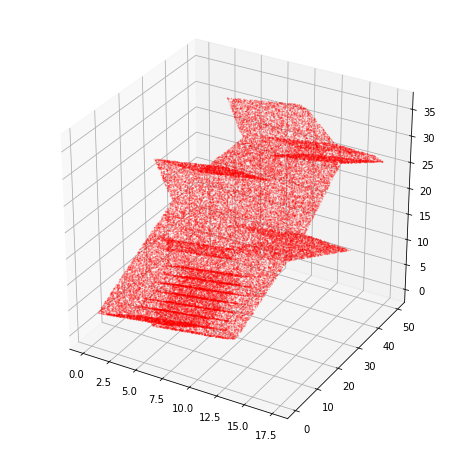

ID of Selection Plotted: 8693


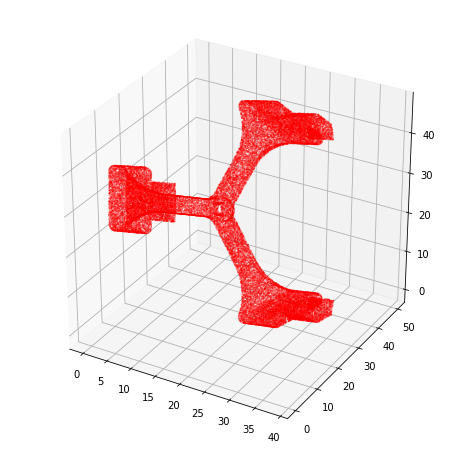

In [132]:
for i in range(Samples):
    Random_Selection = np.random.randint((Training.shape[0]),size=1)[0]
    
    X = Training[Random_Selection,:PointCloudSize]
    Y = Training[Random_Selection,PointCloudSize:PointCloudSize*2]
    Z = Training[Random_Selection,PointCloudSize*2:PointCloudSize*3]
    
    print('ID of Selection Plotted: '+ str(Random_Selection))
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, zdir='z', c= Color, alpha=Alpha, s=size)
    plt.show()
    

# Save the Generated Dataset to a CSV file

In [76]:
np.savetxt("GeneratedData.csv", Training , delimiter=",")